**Introduction**

In this project, I will use machine learning algorithm to predict facies type (classes of rocks) from well log data. The labeled well log data are from real wells of Council Grove gas reservoir in Southwest Kansas. The Panoma Council Grove Field is predominantly a carbonate gas reservoir encompassing 2700 square miles in Southwestern Kansas. There are totally seven features for each well log: gamma ray (GR), resistivity logging (ILD_log10), photoelectric effect (PE), neutron-density porosity difference, average neutron-density porosity (DeltaPHI and PHIND), nonmarine-marine indicator (NM_M), and relative position (RELPOS). Those seven features will be used as predictor variables.

The target, facies, are obtained by examining the cores from the wells taken vertically at half-foot intervals. Below lists the nine facies:


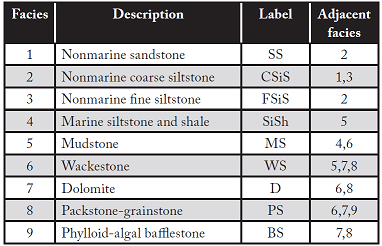

As claimed by the data introduction, the facies aren't discrete, and gradually blend into one another. Some have neighboring facies that are rather close. The adjacent facies of each face are also shown in above list. Mislabeling within these neighboring facies can be expected to occur. So the challenge is to predict the facies accurately.

So the object of this project will be:

Find the most optimal machine learning algorithm to predict the facies from well log.

And the experiment design is:
  1. load and explore the data
  2. pick one well log as blind test well and the other wells for model training
  3. for each algorithm, scan the parameters to get the most optimized parameters and train the model
  4. evaluate the model performance
  5. evaluate the prediction performance by predicting the facies of the blind test well
  6. plot well predicted facies for comparison


**1. Data loading and exploration**

The well log data is download from Github: https://github.com/seg/tutorials-2016/tree/master/1610_Facies_classification

In [ ]:
import pandas as pd
import matplotlib.pylab as plt
import numpy as np

In [ ]:
url = 'https://drive.google.com/file/d/19UU1UL6J-VfnV29AQoVlpWaqoVOdywPO/view?usp=sharing'
path = 'https://drive.google.com/uc?export=download&id='+url.split('/')[-2]
data = pd.read_csv(path)

In [ ]:
data.head()

,Facies,Formation,Well Name,Depth,GR,ILD_log10,DeltaPHI,PHIND,PE,NM_M,RELPOS
0,3,A1 SH,SHRIMPLIN,2793.0,77.45,0.664,9.9,11.915,4.6,1,1.000
1,3,A1 SH,SHRIMPLIN,2793.5,78.26,0.661,14.2,12.565,4.1,1,0.979
2,3,A1 SH,SHRIMPLIN,2794.0,79.05,0.658,14.8,13.050,3.6,1,0.957
3,3,A1 SH,SHRIMPLIN,2794.5,86.10,0.655,13.9,13.115,3.5,1,0.936
4,3,A1 SH,SHRIMPLIN,2795.0,74.58,0.647,13.5,13.300,3.4,1,0.915


In [ ]:
### well name list, there are totla 10 wells
data['Well Name'].unique()

array(['SHRIMPLIN', 'ALEXANDER D', 'SHANKLE', 'LUKE G U', 'KIMZEY A',
       'CROSS H CATTLE', 'NOLAN', 'Recruit F9', 'NEWBY',
       'CHURCHMAN BIBLE'], dtype=object)

In [ ]:
data.describe()

,Facies,Depth,GR,ILD_log10,DeltaPHI,PHIND,PE,NM_M,RELPOS
count,4149.000000,4149.000000,4149.000000,4149.000000,4149.000000,4149.000000,3232.000000,4149.000000,4149.000000
mean,4.503254,2906.867438,64.933985,0.659566,4.402484,13.201066,3.725014,1.518438,0.521852
std,2.474324,133.300164,30.302530,0.252703,5.274947,7.132846,0.896152,0.499720,0.286644
min,1.000000,2573.500000,10.149000,-0.025949,-21.832000,0.550000,0.200000,1.000000,0.000000
25%,2.000000,2821.500000,44.730000,0.498000,1.600000,8.500000,3.100000,1.000000,0.277000
50%,4.000000,2932.500000,64.990000,0.639000,4.300000,12.020000,3.551500,2.000000,0.528000
75%,6.000000,3007.000000,79.438000,0.822000,7.500000,16.050000,4.300000,2.000000,0.769000
max,9.000000,3138.000000,361.150000,1.800000,19.312000,84.400000,8.094000,2.000000,1.000000


Looking at the count values, most values have 4149 valid values except for PE, which has 3232. 

In [ ]:
data.corr()

,Facies,Depth,GR,ILD_log10,DeltaPHI,PHIND,PE,NM_M,RELPOS
Facies,1.000000,0.306688,-0.386677,0.383166,-0.235005,-0.356453,0.704231,0.852721,0.076761
Depth,0.306688,1.000000,-0.088636,0.202272,0.067694,-0.095834,0.277577,0.282318,0.001537
GR,-0.386677,-0.088636,1.000000,-0.205855,0.178863,0.270729,-0.289023,-0.316284,-0.182051
ILD_log10,0.383166,0.202272,-0.205855,1.000000,-0.104827,-0.544416,0.384589,0.493570,0.088227
DeltaPHI,-0.235005,0.067694,0.178863,-0.104827,1.000000,-0.189355,0.011489,-0.177500,0.022470
PHIND,-0.356453,-0.095834,0.270729,-0.544416,-0.189355,1.000000,-0.573418,-0.481024,-0.033328
PE,0.704231,0.277577,-0.289023,0.384589,0.011489,-0.573418,1.000000,0.657089,0.018905
NM_M,0.852721,0.282318,-0.316284,0.493570,-0.177500,-0.481024,0.657089,1.000000,0.034015
RELPOS,0.076761,0.001537,-0.182051,0.088227,0.022470,-0.033328,0.018905,0.034015,1.000000


All the features are weakly correlated to each other. While PE is highly correlated to Facies, so I want to drop the rows without PE values rather than to interpolate them. After dropping, there are still large enough variable numbers for model training.

In [ ]:
data_dropna = data.dropna(axis=0)
data_dropna.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3232 entries, 0 to 4148
Data columns (total 11 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Facies     3232 non-null   int64  
 1   Formation  3232 non-null   object 
 2   Well Name  3232 non-null   object 
 3   Depth      3232 non-null   float64
 4   GR         3232 non-null   float64
 5   ILD_log10  3232 non-null   float64
 6   DeltaPHI   3232 non-null   float64
 7   PHIND      3232 non-null   float64
 8   PE         3232 non-null   float64
 9   NM_M       3232 non-null   int64  
 10  RELPOS     3232 non-null   float64
dtypes: float64(7), int64(2), object(2)
memory usage: 303.0+ KB


In [ ]:
data_dropna['Well Name'].unique()

array(['SHRIMPLIN', 'SHANKLE', 'LUKE G U', 'CROSS H CATTLE', 'NOLAN',
       'Recruit F9', 'NEWBY', 'CHURCHMAN BIBLE'], dtype=object)

Two wells are exluded from data after dropping Nan.

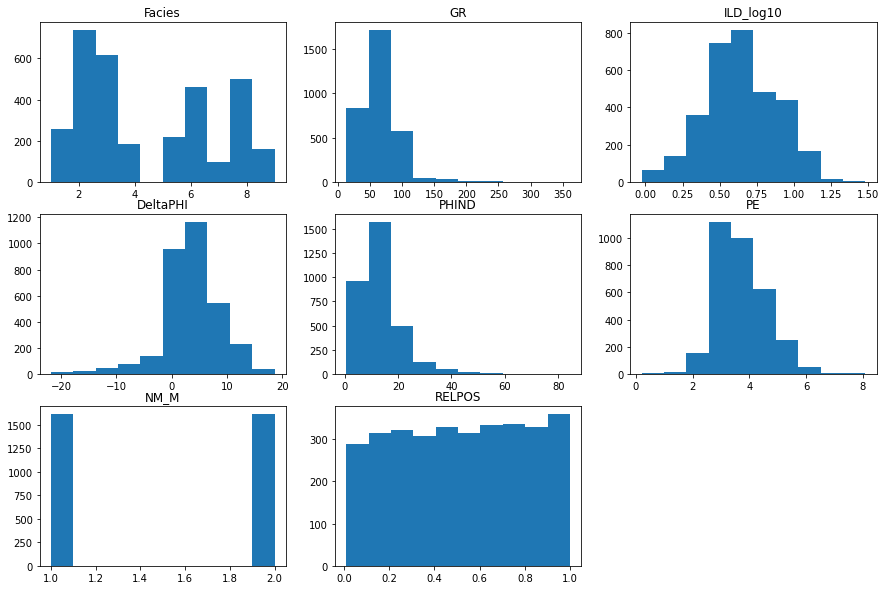

In [ ]:
col_list = ['Facies', 'GR',	'ILD_log10',	'DeltaPHI',	'PHIND',	'PE',	'NM_M',	'RELPOS']
plt.figure(figsize=(15,10))
i=0
for col in col_list:
  i+=1
  plt.subplot(3,3,i)
  plt.hist(data_dropna[col])
  plt.title(col)
plt.show()

1    259
2    738
3    615
4    184
5    217
6    462
7     98
8    498
9    161
Name: Facies, dtype: int64


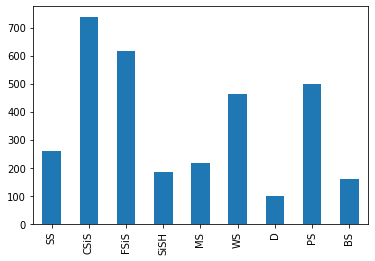

In [ ]:
#plot the count of Facies
data_dropna['Facies'].value_counts().sort_index().plot(kind='bar')
print(data_dropna['Facies'].value_counts().sort_index())
X_ind = np.arange(0,9,1)
plt.xticks(X_ind,['SS', 'CSiS', 'FSiS', 'SiSH', 'MS', 'WS','D','PS','BS'])
plt.show()

**2. Prepare data for modeling and blind test well**

The well 'SHANKLE' is taken as blind test well and other wells for modeling.

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC

from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import cross_val_score

from sklearn.metrics import confusion_matrix, precision_score, recall_score
from sklearn.metrics import classification_report

In [ ]:
test_well = data_dropna[data['Well Name']=='SHANKLE']
data_4mod = data_dropna[data['Well Name']!='SHANKLE']
features = ['GR',	'ILD_log10',	'DeltaPHI',	'PHIND',	'PE',	'NM_M',	'RELPOS']
y = data_4mod['Facies']
X = data_4mod[features]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


In [ ]:
### Data for modelling

scaler = StandardScaler().fit(X)
X_stnd = scaler.transform(X)

# standarization of data for SVM
X_train, X_test, y_train, y_test = train_test_split(X_stnd, y, test_size=0.05, random_state=42)
X1_train, X1_test, y1_train, y1_test = train_test_split(X, y, test_size=0.05, random_state=42)

In [ ]:
### Blind test well

y_test_well = test_well['Facies']
X_test_well = test_well[features]
X_test_well_stnd = scaler.transform(X_test_well)

**3. Parameter optimization and classifier training**

Modeling algorithms:
1. SVM
2. Gradient boosting
3. Random forest
4. KNN

In [ ]:
from sklearn.svm import SVC
from sklearn import ensemble
from sklearn.neighbors import KNeighborsClassifier

3.1. SVM: Parameter optimiztion

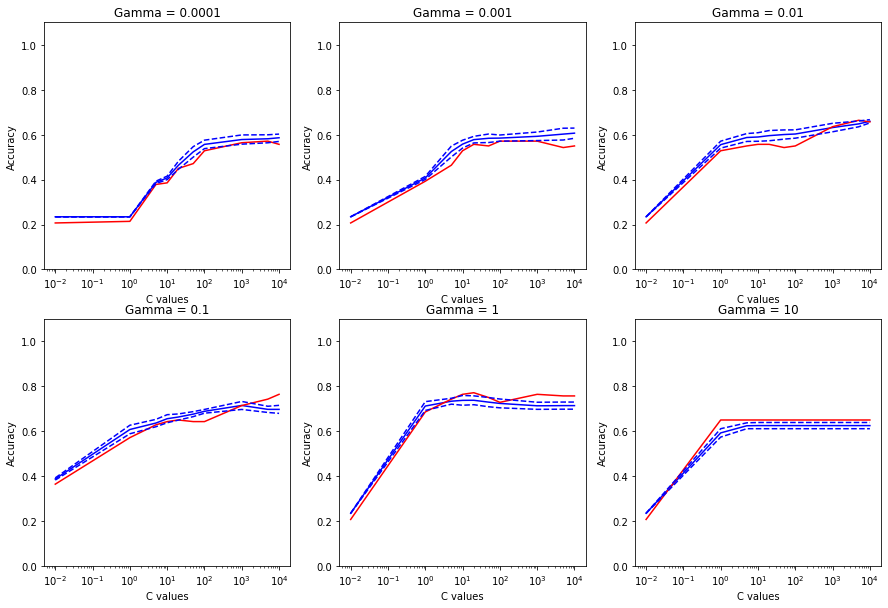

In [ ]:
c_list = [0.01, 1, 5, 10, 20, 50, 100, 1000, 5000, 10000]
gamma_list = [0.0001, 0.001, 0.01, 0.1, 1, 10]

i = 0
plt.figure(figsize=(15,10))

for gamma_value in gamma_list:

  i = i + 1
  scores = list()
  score_stds = list()
  score_tests = list()

  for c_value in c_list:

    clf_cv = SVC(C=c_value, gamma=gamma_value)
    cv_score = cross_val_score(clf_cv, X_train, y_train)
    scores.append(np.mean(cv_score))
    score_stds.append(np.std(cv_score))
    clf_cv.fit(X_train, y_train)
    score_test = clf_cv.score(X_test, y_test)
    score_tests.append(score_test)

  plt.subplot(2,3,i)
  plt.semilogx(c_list, scores, 'b')
  plt.semilogx(c_list, score_tests, 'r')
  plt.semilogx(c_list, np.array(scores)+np.array(score_stds), 'b--')
  plt.semilogx(c_list, np.array(scores)+-np.array(score_stds), 'b--')
  plt.title('Gamma = {}'.format(gamma_value))
  plt.xlabel('C values')
  plt.ylabel('Accuracy')
  plt.ylim(0,1.1)

plt.show()


Gamma = 1 and C = 10 give the best accuracy.

SVM classifier training

In [ ]:
clf = SVC(C=10, gamma=1)
clf.fit(X_train, y_train)

SVC(C=10, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=1, kernel='rbf', max_iter=-1,
    probability=False, random_state=None, shrinking=True, tol=0.001,
    verbose=False)

In [ ]:
def plot_confusion_matrix(cm, classes,normalize,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    import itertools

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center", verticalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


              precision    recall  f1-score   support

          SS       1.00      0.69      0.81        16
        CSiS       0.83      0.86      0.85        29
        FSiS       0.65      0.93      0.76        14
        SiSH       0.44      0.57      0.50         7
          MS       0.83      0.56      0.67        18
          WS       0.65      0.74      0.69        23
           D       0.50      0.33      0.40         3
          PS       0.83      0.83      0.83        23
          BS       1.00      1.00      1.00         7

    accuracy                           0.76       140
   macro avg       0.75      0.72      0.72       140
weighted avg       0.79      0.76      0.76       140

Normalized confusion matrix


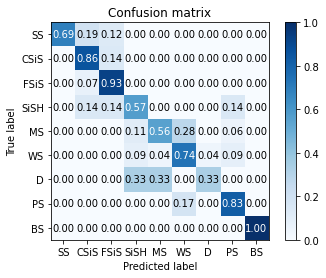

In [ ]:
pred_test = clf.predict(X_test)
target_list = ['SS', 'CSiS', 'FSiS', 'SiSH', 'MS', 'WS','D','PS','BS']
print(classification_report(y_test, pred_test, target_names=target_list))
cm_test_SVM = confusion_matrix(y_test, pred_test)
plot_confusion_matrix(cm_test_SVM, target_list, normalize=True)

SVM blind well prediction

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()


              precision    recall  f1-score   support

          SS       0.30      0.08      0.12        89
        CSiS       0.36      0.72      0.48        89
        FSiS       0.62      0.54      0.58       117
        SiSH       0.25      0.29      0.27         7
          MS       0.17      0.11      0.13        19
          WS       0.66      0.54      0.59        71
           D       0.71      0.29      0.42        17
          PS       0.41      0.60      0.49        40
          BS       0.00      0.00      0.00         0

    accuracy                           0.46       449
   macro avg       0.39      0.35      0.34       449
weighted avg       0.47      0.46      0.43       449

Normalized confusion matrix


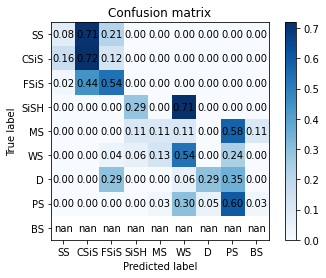

In [ ]:
pred_test_well = clf.predict(X_test_well_stnd)
print(classification_report(y_test_well, pred_test_well, target_names=target_list))
cm_SVM = confusion_matrix(y_test_well, pred_test_well)
plot_confusion_matrix(cm_SVM, target_list, normalize=True)

3.2 Gradient boosting (GB): Parameter optimiztion

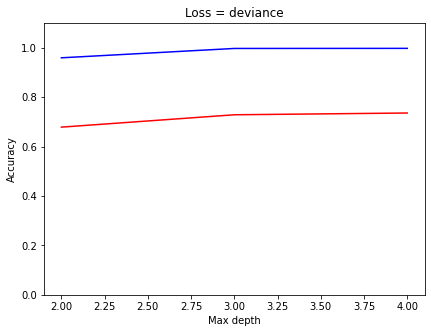

In [ ]:
loss_list = ['deviance']
max_depths = [2, 3, 4]

i = 0
plt.figure(figsize=(15,5))

for los in loss_list:

  i = i + 1
  scores = list()
  score_tests = list()

  for depth in max_depths:

    params = {'loss': los, ##  loss{‘deviance’, ‘exponential’}, default=’deviance’
          'learning_rate': 0.1, ##  learning_ratefloat, default=0.1
          'n_estimators': 500, ##  number of iterations, int, default=100
          'max_depth': depth, ##  int, default=3
          'subsample': 1, ## float, default=1.0
          'min_samples_split': 2 ## int or float, default=2
          }
    clf_cv = ensemble.GradientBoostingClassifier(**params)
    clf_cv.fit(X1_train, y1_train)
    cv_score = clf_cv.score(X1_train, y1_train)
    scores.append(np.mean(cv_score))
    score_test = clf_cv.score(X1_test, y1_test)
    score_tests.append(score_test)

  plt.subplot(1,2,i)
  plt.plot(max_depths, scores, 'b')
  plt.plot(max_depths, score_tests, 'r')
  plt.title('Loss = {}'.format(los))
  plt.xlabel('Max depth')
  plt.ylabel('Accuracy')
  plt.ylim(0,1.1)

plt.show()

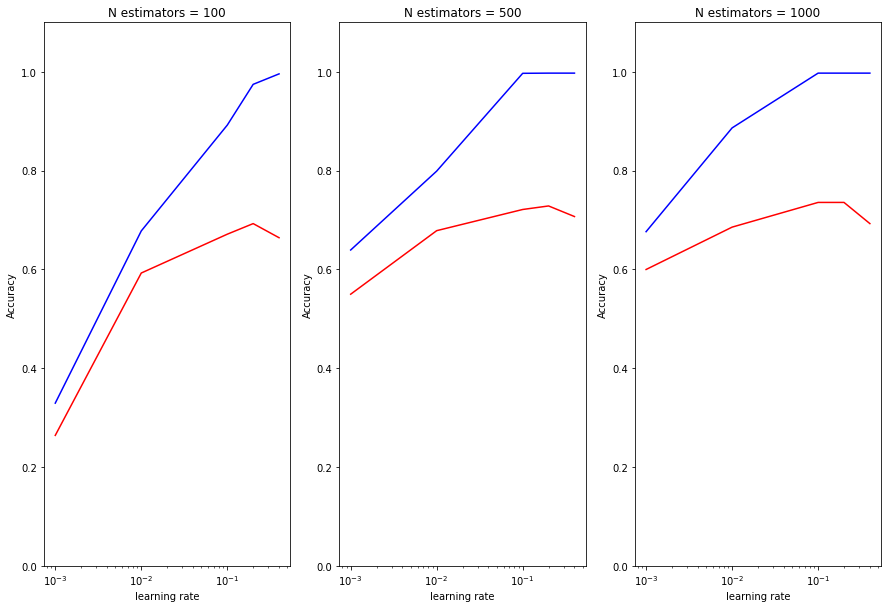

In [ ]:
learning_rates = [0.001, 0.01, 0.1, 0.2, 0.4]
n_estimators_list = [100, 500, 1000]

i = 0
plt.figure(figsize=(15,10))

for est in n_estimators_list:

  i = i + 1
  scores = list()
  score_tests = list()

  for rate in learning_rates:

    params = {'loss': 'deviance', ##  loss{‘deviance’, ‘exponential’}, default=’deviance’
          'learning_rate': rate, ##  learning_ratefloat, default=0.1
          'n_estimators': est, ##  number of iterations, int, default=100
          'max_depth': 3, ##  int, default=3
          'subsample': 1, ## float, default=1.0
          'min_samples_split': 2 ## int or float, default=2
          }
    clf_cv = ensemble.GradientBoostingClassifier(**params)
    clf_cv.fit(X1_train, y1_train)
    cv_score = clf_cv.score(X1_train, y1_train)
    scores.append(np.mean(cv_score))
    score_test = clf_cv.score(X1_test, y1_test)
    score_tests.append(score_test)

  plt.subplot(1,3,i)
  plt.semilogx(learning_rates, scores, 'b')
  plt.semilogx(learning_rates, score_tests, 'r')
  plt.title('N estimators = {}'.format(est))
  plt.xlabel('learning rate')
  plt.ylabel('Accuracy')
  plt.ylim(0,1.1)

plt.show()

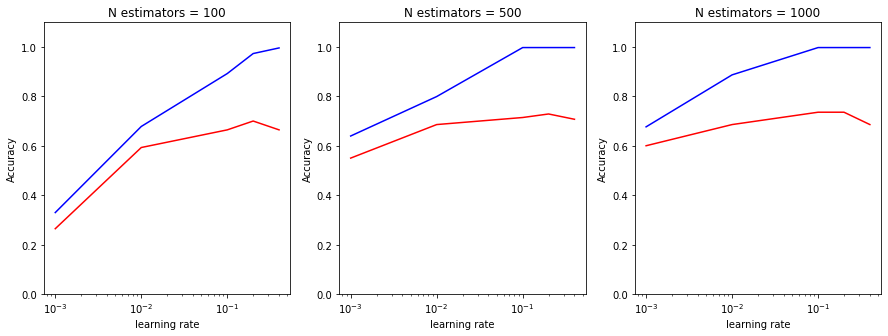

In [ ]:
learning_rates = [0.001, 0.01, 0.1, 0.2, 0.4]
n_estimators_list = [100, 500, 1000]

i = 0
plt.figure(figsize=(15,5))

for est in n_estimators_list:

  i = i + 1
  scores = list()
  score_tests = list()

  for rate in learning_rates:

    params = {'loss': 'deviance', ##  loss{‘deviance’, ‘exponential’}, default=’deviance’
          'learning_rate': rate, ##  learning_ratefloat, default=0.1
          'n_estimators': est, ##  number of iterations, int, default=100
          'max_depth': 3, ##  int, default=3
          'subsample': 1, ## float, default=1.0
          'min_samples_split': 2 ## int or float, default=2
          }
    clf_cv = ensemble.GradientBoostingClassifier(**params)
    clf_cv.fit(X1_train, y1_train)
    cv_score = clf_cv.score(X1_train, y1_train)
    scores.append(np.mean(cv_score))
    score_test = clf_cv.score(X1_test, y1_test)
    score_tests.append(score_test)

  plt.subplot(1,3,i)
  plt.semilogx(learning_rates, scores, 'b')
  plt.semilogx(learning_rates, score_tests, 'r')
  plt.title('N estimators = {}'.format(est))
  plt.xlabel('learning rate')
  plt.ylabel('Accuracy')
  plt.ylim(0,1.1)

plt.show()

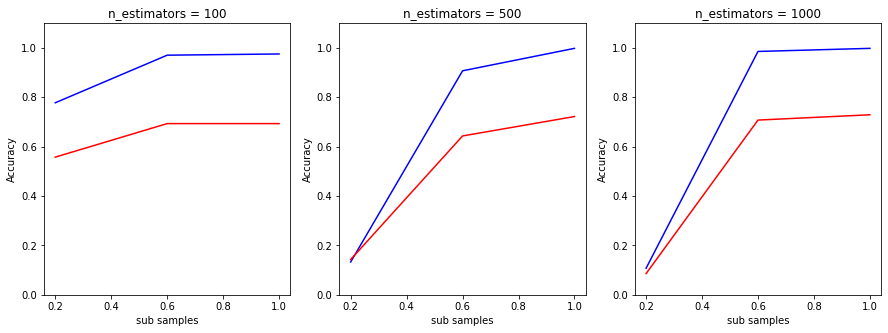

In [ ]:
subsamples = [0.2, 0.6, 1]
n_estimators_list = [100, 500, 1000]

i = 0
plt.figure(figsize=(15,5))

for est in n_estimators_list:

  i = i + 1
  scores = list()
  score_tests = list()

  for sub in subsamples:

    params = {'loss': 'deviance', ##  loss{‘deviance’, ‘exponential’}, default=’deviance’
          'learning_rate': 0.2, ##  learning_ratefloat, default=0.1
          'n_estimators': est, ##  number of iterations, int, default=100
          'max_depth': 3, ##  int, default=3
          'subsample': sub, ## float, default=1.0
          'min_samples_split': 2 ## int or float, default=2
          }
    clf_cv = ensemble.GradientBoostingClassifier(**params)
    clf_cv.fit(X_train, y_train)
    cv_score = clf_cv.score(X_train, y_train)
    scores.append(np.mean(cv_score))
    score_test = clf_cv.score(X_test, y_test)
    score_tests.append(score_test)

  plt.subplot(1,3,i)
  plt.plot(subsamples, scores, 'b')
  plt.plot(subsamples, score_tests, 'r')
  plt.title('n_estimators = {}'.format(est))
  plt.xlabel('sub samples')
  plt.ylabel('Accuracy')
  plt.ylim(0,1.1)

plt.show()

Based on the accuracy plot, max_depth=3, learning_rate=0.2, n_estimators=1000, subsample=0.6

GB classifer training

In [ ]:
params = {'loss': 'deviance', ##  loss{‘deviance’, ‘exponential’}, default=’deviance’
          'learning_rate': 0.2, ##  learning_ratefloat, default=0.1
          'n_estimators': 1000, ##  number of iterations, int, default=100
          'max_depth': 3, ##  int, default=3
          'subsample': 0.6, ## float, default=1.0
          'min_samples_split': 2 ## int or float, default=2
          }
clf_GB = ensemble.GradientBoostingClassifier(**params)
print(cross_val_score(clf_GB, X1_train, y1_train, cv=5))

[0.65406427 0.7221172  0.65028355 0.62121212 0.66098485]


              precision    recall  f1-score   support

           1       1.00      0.56      0.72        16
           2       0.74      0.86      0.79        29
           3       0.71      0.86      0.77        14
           4       0.62      0.71      0.67         7
           5       0.82      0.50      0.62        18
           6       0.54      0.57      0.55        23
           7       1.00      0.67      0.80         3
           8       0.68      0.74      0.71        23
           9       0.70      1.00      0.82         7

    accuracy                           0.71       140
   macro avg       0.76      0.72      0.72       140
weighted avg       0.73      0.71      0.70       140

Normalized confusion matrix


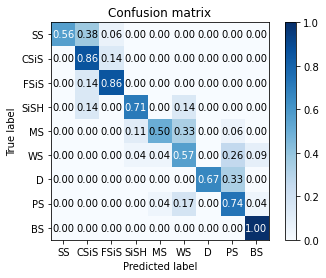

In [ ]:
params = {'loss': 'deviance', ##  loss{‘deviance’, ‘exponential’}, default=’deviance’
          'learning_rate': 0.2, ##  learning_ratefloat, default=0.1
          'n_estimators': 1000, ##  number of iterations, int, default=100
          'max_depth': 3, ##  int, default=3
          'subsample': 0.6, ## float, default=1.0
          'min_samples_split': 2 ## int or float, default=2
          }
clf_GB = ensemble.GradientBoostingClassifier(**params)
clf_GB.fit(X1_train, y1_train)
preds_GB = clf_GB.predict(X1_test)
print(classification_report(y1_test, preds_GB))
cm_test_GB = confusion_matrix(y1_test, preds_GB)
plot_confusion_matrix(cm_test_GB, target_list, normalize=True)

GB blind well predictin

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()


              precision    recall  f1-score   support

          SS       0.50      0.07      0.12        89
        CSiS       0.34      0.76      0.47        89
        FSiS       0.77      0.54      0.63       117
        SiSH       0.05      0.14      0.08         7
          MS       0.11      0.11      0.11        19
          WS       0.66      0.61      0.63        71
           D       0.83      0.29      0.43        17
          PS       0.48      0.50      0.49        40
          BS       0.00      0.00      0.00         0

    accuracy                           0.46       449
   macro avg       0.41      0.34      0.33       449
weighted avg       0.55      0.46      0.45       449

Normalized confusion matrix


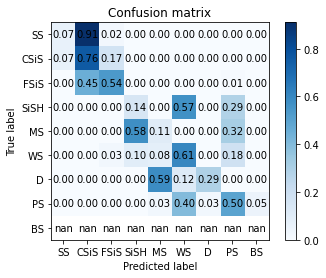

In [ ]:
pred_GB_test_well = clf_GB.predict(X_test_well)
print(classification_report(y_test_well, pred_GB_test_well, target_names=['SS', 'CSiS', 'FSiS', 'SiSH', 'MS', 'WS','D','PS', 'BS']))
cm_GB = confusion_matrix(y_test_well, pred_GB_test_well)
plot_confusion_matrix(cm_GB, target_list, normalize=True)

3.3. Random forest (RF) parameter optimization

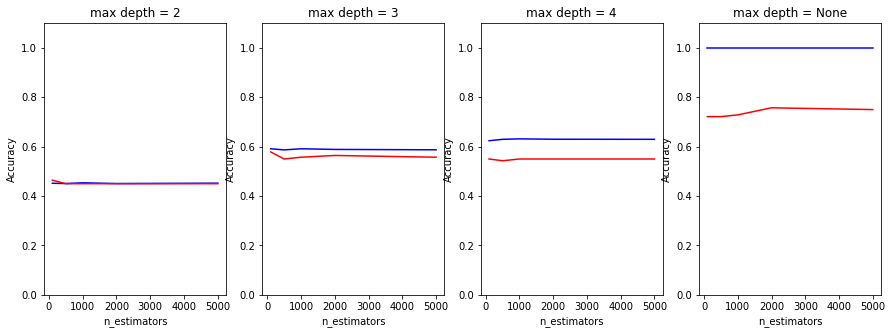

In [ ]:
max_depths = [2, 3, 4]
n_estimators_list = [100, 500, 1000, 2000, 5000]

i = 0
plt.figure(figsize=(15,5))

for depth in max_depths:

  i = i + 1
  scores = list()
  score_tests = list()

  for est in n_estimators_list:

    params = {'n_estimators': est, ##  number of iterations, int, default=100
          'max_depth': depth, ##  int, default=3
          }
    clf_cv = ensemble.RandomForestClassifier(**params)
    clf_cv.fit(X1_train, y1_train)
    cv_score = clf_cv.score(X1_train, y1_train)
    scores.append(np.mean(cv_score))
    score_test = clf_cv.score(X1_test, y1_test)
    score_tests.append(score_test)

  plt.subplot(1,4,i)
  plt.plot(n_estimators_list, scores, 'b')
  plt.plot(n_estimators_list, score_tests, 'r')
  plt.title('max depth = {}'.format(depth))
  plt.xlabel('n_estimators')
  plt.ylabel('Accuracy')
  plt.ylim(0,1.1)

scores = list()
score_tests = list()
for est in n_estimators_list:
  clf_cv = ensemble.RandomForestClassifier(n_estimators=est)
  clf_cv.fit(X1_train, y1_train)
  cv_score = clf_cv.score(X1_train, y1_train)
  scores.append(np.mean(cv_score))
  score_test = clf_cv.score(X1_test, y1_test)
  score_tests.append(score_test)
plt.subplot(1,4,4)
plt.plot(n_estimators_list, scores, 'b')
plt.plot(n_estimators_list, score_tests, 'r')
plt.title('max depth = {}'.format('None'))
plt.xlabel('n_estimators')
plt.ylabel('Accuracy')
plt.ylim(0,1.1)
plt.show()

Max_depth can be default (None), and n_estimator = 2000 gives best accuracy.

RF classifier training

[0.70888469 0.75614367 0.70510397 0.73106061 0.71022727]
              precision    recall  f1-score   support

           1       1.00      0.62      0.77        16
           2       0.74      0.90      0.81        29
           3       0.73      0.79      0.76        14
           4       0.56      0.71      0.63         7
           5       0.88      0.39      0.54        18
           6       0.64      0.70      0.67        23
           7       1.00      1.00      1.00         3
           8       0.67      0.78      0.72        23
           9       0.88      1.00      0.93         7

    accuracy                           0.74       140
   macro avg       0.79      0.77      0.76       140
weighted avg       0.76      0.74      0.73       140

Normalized confusion matrix


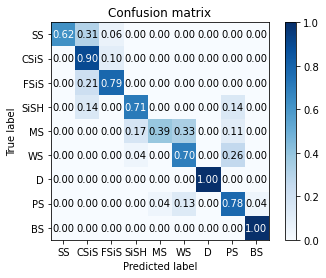

In [ ]:
clf_RF = ensemble.RandomForestClassifier(n_estimators=2000)
print(cross_val_score(clf_RF, X1_train, y1_train, cv=5))
clf_RF.fit(X1_train, y1_train)
preds_RF = clf_RF.predict(X1_test)
print(classification_report(y1_test, preds_RF))
cm_test_RF = confusion_matrix(y1_test, preds_RF)
plot_confusion_matrix(cm_test_RF, target_list, normalize=True)

RF blind well prediction

              precision    recall  f1-score   support

           1       0.38      0.06      0.10        89
           2       0.36      0.79      0.49        89
           3       0.85      0.63      0.73       117
           4       0.07      0.14      0.09         7
           5       0.38      0.16      0.22        19
           6       0.67      0.65      0.66        71
           7       0.92      0.71      0.80        17
           8       0.53      0.62      0.57        40

    accuracy                           0.53       449
   macro avg       0.52      0.47      0.46       449
weighted avg       0.57      0.53      0.50       449

Normalized confusion matrix


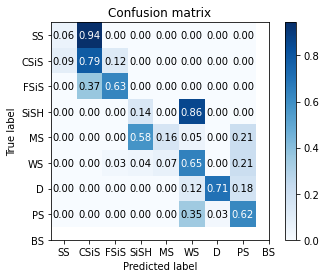

In [ ]:
preds_RF_test_well = clf_RF.predict(X_test_well)
print(classification_report(y_test_well, preds_RF_test_well))
cm_RF = confusion_matrix(y_test_well, preds_RF_test_well)
plot_confusion_matrix(cm_RF, target_list, normalize=True)

3.4. KNN Parameter optimzation

[0.6662883087400681]
[0.6662883087400681, 0.6348846008323874]
[0.6662883087400681, 0.6348846008323874, 0.6008323874385169]
[0.9973514945138101]
[0.9973514945138101, 0.9973514945138101]
[0.9973514945138101, 0.9973514945138101, 0.9973514945138101]


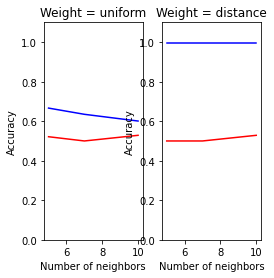

In [ ]:
neighbor_list = [5, 7, 10]
weight_list = ['uniform', 'distance']
i=0

for weight in weight_list:
  scores = list()
  score_tests = list()
  i = i + 1

  for neighbor in neighbor_list:
    clf_cv = KNeighborsClassifier(n_neighbors=neighbor, weights=weight)
    clf_cv.fit(X1_train, y1_train)
    scores.append(clf_cv.score(X1_train, y1_train))
    score_tests.append(clf_cv.score(X1_test, y1_test))
    print(scores)

  plt.subplot(1,3,i)
  plt.plot(neighbor_list, scores, 'b')
  plt.plot(neighbor_list, score_tests, 'r')
  plt.title('Weight = {}'.format(weight))
  plt.xlabel('Number of neighbors')
  plt.ylabel('Accuracy')
  plt.ylim(0,1.1)
plt.show()


Using weight has a better KNN modeling score.

KNN classifer training

In [ ]:
clf_knn = KNeighborsClassifier(weights='distance')
print(cross_val_score(clf_knn, X1_train, y1_train, cv=5))

[0.53497164 0.51228733 0.5557656  0.48295455 0.52462121]


              precision    recall  f1-score   support

           1       0.78      0.44      0.56        16
           2       0.49      0.59      0.53        29
           3       0.45      0.71      0.56        14
           4       0.14      0.14      0.14         7
           5       0.60      0.33      0.43        18
           6       0.45      0.39      0.42        23
           7       0.50      0.33      0.40         3
           8       0.54      0.57      0.55        23
           9       0.55      0.86      0.67         7

    accuracy                           0.50       140
   macro avg       0.50      0.48      0.47       140
weighted avg       0.52      0.50      0.49       140

Normalized confusion matrix


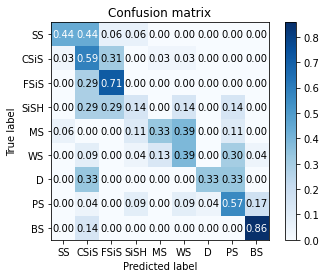

In [ ]:
clf_knn = KNeighborsClassifier(weights='distance')
clf_knn.fit(X1_train, y1_train)
preds_knn = clf_knn.predict(X1_test)
print(classification_report(y1_test, preds_knn))
cm_test_knn = confusion_matrix(y1_test, preds_knn)
plot_confusion_matrix(cm_test_knn, target_list, normalize=True)

KNN blind well prediction

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()


              precision    recall  f1-score   support

           1       0.58      0.33      0.42        89
           2       0.35      0.61      0.45        89
           3       0.72      0.51      0.60       117
           4       0.08      0.14      0.11         7
           5       0.00      0.00      0.00        19
           6       0.62      0.51      0.56        71
           7       0.22      0.24      0.23        17
           8       0.29      0.38      0.33        40
           9       0.00      0.00      0.00         0

    accuracy                           0.44       449
   macro avg       0.32      0.30      0.30       449
weighted avg       0.51      0.44      0.46       449

Normalized confusion matrix


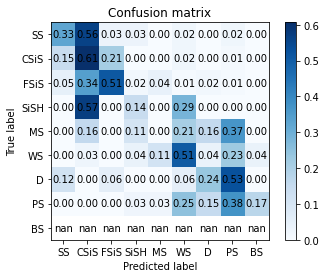

In [ ]:
preds_knn_test_well = clf_knn.predict(X_test_well)
print(classification_report(y_test_well, preds_knn_test_well))
cm_knn = confusion_matrix(y_test_well, preds_knn_test_well)
plot_confusion_matrix(cm_knn, target_list, normalize=True)

**4. Model performance evaluation**

I will use the diagnosis of confusion matrix from train data set to evaluate the model performance. The diagnosis of confusion matrix points how much percentage of the stone is correctly predicted.

In [ ]:
### To create a data frame recording the correct prediction (normalized) of facies for each machine learning algorithm

mod_test_list = ['SVM', 'GB', 'RF','KNN']
cm_test_list = [cm_test_SVM, cm_test_GB, cm_test_RF, cm_test_knn]
face_test_list = ['SS', 'CSiS', 'FSiS', 'SiSH', 'MS', 'WS','D','PS']
pred_test_df = pd.DataFrame(index=target_list, columns=mod_test_list)

for mod in mod_test_list:
  col_index = int(mod_test_list.index(mod))
  cm = cm_test_list[col_index]

  for face in face_test_list:
    row_index = target_list.index(face)
    #print(face, row_index, col_index)
    pred_test_df.iloc[row_index, col_index] = cm[row_index][row_index]/sum(cm[row_index])

### add the accuracy factor
df_1 = pd.DataFrame([[0.72, 0.74, 0.74, 0.50]], index=['Accuracy'], columns=mod_test_list)    
pred_test_df = pred_test_df.append(df_1)

print(pred_test_df.head(10))

               SVM        GB        RF       KNN
SS          0.6875       0.5     0.625    0.4375
CSiS      0.862069  0.862069  0.896552  0.586207
FSiS      0.928571  0.785714  0.785714  0.714286
SiSH      0.571429  0.714286  0.714286  0.142857
MS        0.555556  0.555556  0.388889  0.333333
WS         0.73913   0.73913   0.73913  0.391304
D         0.333333  0.666667         1  0.333333
PS        0.826087  0.826087  0.782609  0.565217
BS             NaN       NaN       NaN       NaN
Accuracy      0.72      0.74      0.74       0.5


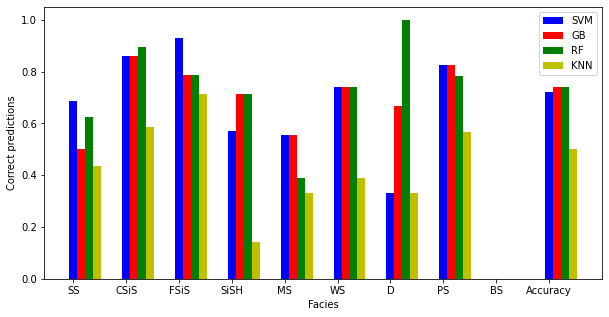

In [ ]:
X_ind = np.arange(pred_test_df.shape[0])
(pred_df_index_list) = ['SS', 'CSiS', 'FSiS', 'SiSH', 'MS', 'WS','D','PS','BS', 'Accuracy']
plt.figure(figsize=(10,5))
plt.bar(X_ind, pred_test_df['SVM'], color='b', width=0.15)
plt.bar(X_ind+0.15, pred_test_df['GB'], color='r', width=0.15)
plt.bar(X_ind+0.3, pred_test_df['RF'], color='g', width=0.15)
plt.bar(X_ind+0.45, pred_test_df['KNN'], color='y', width=0.15)
plt.xticks(X_ind, pred_df_index_list)
plt.xlabel('Facies')
plt.ylabel('Correct predictions')
plt.legend(labels=mod_test_list)
plt.show()

1. All four algorithms predict 0 BS, which is consistent with the blind test well.
2. SVM, GB, and RF present very close accuracy score, while KNN's is much lower than the others.
3. RF could correctly predict much more Dolomite(D) than the other algorithms, while SVM, GB, and RF have the same correct prediction for other facies, such as Wackstone(WS).
4. we can use the prediction performance using blind well for further evaluation.

**5. Calssifier evluation using blind test well**

I will use the same method shown in item4 for evaluation.

In [ ]:
### To create a data frame recording the correct prediction (normalized) of facies of blind test well for each machine learning algorithm

mod_list = ['SVM', 'GB', 'RF','KNN']
cm_list = [cm_SVM, cm_GB, cm_RF, cm_knn]
face_list = ['SS', 'CSiS', 'FSiS', 'SiSH', 'MS', 'WS','D','PS']
pred_df = pd.DataFrame(index=target_list, columns=mod_list)

for mod in mod_list:
  col_index = int(mod_list.index(mod))
  cm = cm_list[col_index]

  for face in face_list:
    row_index = target_list.index(face)
    #print(face, row_index, col_index)
    pred_df.iloc[row_index, col_index] = cm[row_index][row_index]/sum(cm[row_index])


print(pred_df.head(10))


            SVM         GB         RF       KNN
SS    0.0786517  0.0674157  0.0561798  0.325843
CSiS   0.719101   0.764045   0.786517  0.606742
FSiS   0.538462   0.538462   0.632479  0.512821
SiSH   0.285714   0.142857   0.142857  0.142857
MS     0.105263   0.105263   0.157895         0
WS     0.535211   0.605634   0.647887  0.507042
D      0.294118   0.294118   0.705882  0.235294
PS          0.6        0.5      0.625     0.375
BS          NaN        NaN        NaN       NaN


In [ ]:
### add the accuracy factor and percentage of most correct prediction
df_1 = pd.DataFrame([[0.46, 0.49, 0.53, 0.44],[0.125,0.125,0.375,0.375]], index=['Accuracy','prec'], columns=mod_list)    
pred_df = pred_df.append(df_1)
pred_df.head(13)

,SVM,GB,RF,KNN
SS,0.0786517,0.0674157,0.0561798,0.325843
CSiS,0.719101,0.764045,0.786517,0.606742
FSiS,0.538462,0.538462,0.632479,0.512821
SiSH,0.285714,0.142857,0.142857,0.142857
MS,0.105263,0.105263,0.157895,0
WS,0.535211,0.605634,0.647887,0.507042
D,0.294118,0.294118,0.705882,0.235294
PS,0.6,0.5,0.625,0.375
BS,NaN,NaN,NaN,NaN
Accuracy,0.46,0.49,0.53,0.44


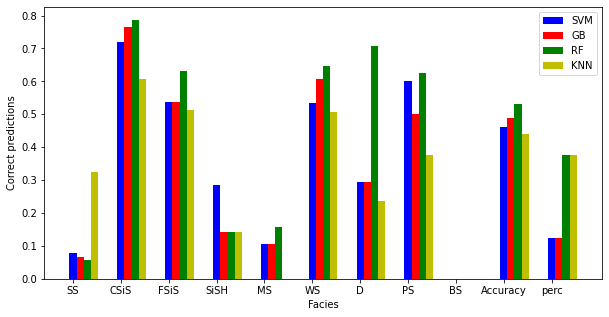

In [ ]:
X_ind = np.arange(pred_df.shape[0])
(pred_df_index_list) = ['SS', 'CSiS', 'FSiS', 'SiSH', 'MS', 'WS','D','PS','BS','Accuracy','perc']
plt.figure(figsize=(10,5))
plt.bar(X_ind, pred_df['SVM'], color='b', width=0.15)
plt.bar(X_ind+0.15, pred_df['GB'], color='r', width=0.15)
plt.bar(X_ind+0.3, pred_df['RF'], color='g', width=0.15)
plt.bar(X_ind+0.45, pred_df['KNN'], color='y', width=0.15)
plt.xticks(X_ind, pred_df_index_list)
plt.xlabel('Facies')
plt.ylabel('Correct predictions')
plt.legend(labels=mod_list)
plt.show()


Based on the performance of blind well test, RF overall has the highest accuracy score, and shows most correct prediction at three facies (WS, D, and PS). KNN amazingly also shows most correct prediction at three facies (SS, FSiS, and MS), and the accuracy score is close to the others. In additional, the accuracy score is much lower than those from train data set. So there is still a room for improvement. Perhaps introducing more wells could help. Improving data quality could be another option. On the other hand, we have not labeled the importance of each stone, since non-marine stones usually correspond to high probability of oil and gas. After labeling the importance of stones, we would have better evaluation criteria for performance of the algorithms.

**6. Plot the predicted facies for comparison**

In [ ]:
blind = test_well.copy()
blind['predict_SVM'] = pred_test_well
blind['predict_GB'] = pred_GB_test_well
blind['predict_RF'] = preds_RF_test_well
blind['predict_KNN'] = preds_knn_test_well
blind.head()

,Facies,Formation,Well Name,Depth,GR,ILD_log10,DeltaPHI,PHIND,PE,NM_M,RELPOS,predict_SVM,predict_GB,predict_RF,predict_KNN
937,2,A1 SH,SHANKLE,2774.5,98.36,0.642,-0.1,18.685,2.9,1,1.000,2,3,3,2
938,2,A1 SH,SHANKLE,2775.0,97.57,0.631,7.9,16.745,3.2,1,0.984,2,3,3,2
939,2,A1 SH,SHANKLE,2775.5,98.41,0.615,12.8,14.105,3.2,1,0.968,2,2,2,3
940,2,A1 SH,SHANKLE,2776.0,85.92,0.597,13.0,13.385,3.4,1,0.952,2,3,3,2
941,2,A1 SH,SHANKLE,2776.5,83.16,0.592,12.3,13.345,3.4,1,0.935,2,2,3,2


In [ ]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from mpl_toolkits.axes_grid1 import make_axes_locatable

facies_colors = ['#F4D03F', '#F5B041','#DC7633','#6E2C00',
       '#1B4F72','#2E86C1', '#AED6F1', '#A569BD', '#196F3D']

def compare_facies_plot(logs, compare1, compare2, compare3, compare4, facies_colors):
      #make sure logs are sorted by depth
    logs = logs.sort_values(by='Depth')
    cmap_facies = colors.ListedColormap(
            facies_colors[0:len(facies_colors)], 'indexed')
    
    ztop=logs.Depth.min(); zbot=logs.Depth.max()
    
    cluster0 = np.repeat(np.expand_dims(logs['Facies'].values,1), 100, 1)
    cluster1 = np.repeat(np.expand_dims(logs[compare1].values,1), 100, 1)
    cluster2 = np.repeat(np.expand_dims(logs[compare2].values,1), 100, 1)
    cluster3 = np.repeat(np.expand_dims(logs[compare3].values,1), 100, 1)
    cluster4 = np.repeat(np.expand_dims(logs[compare4].values,1), 100, 1)
    
    f, ax = plt.subplots(nrows=1, ncols=10, figsize=(15, 12))
    ax[0].plot(logs.GR, logs.Depth, '-g')
    ax[1].plot(logs.ILD_log10, logs.Depth, '-')
    ax[2].plot(logs.DeltaPHI, logs.Depth, '-', color='0.5')
    ax[3].plot(logs.PHIND, logs.Depth, '-', color='r')
    ax[4].plot(logs.PE, logs.Depth, '-', color='black')
    im0 = ax[5].imshow(cluster0, interpolation='none', aspect='auto',
                    cmap=cmap_facies,vmin=1,vmax=9)
    im1 = ax[6].imshow(cluster1, interpolation='none', aspect='auto',
                    cmap=cmap_facies,vmin=1,vmax=9)
    im2 = ax[7].imshow(cluster2, interpolation='none', aspect='auto',
                    cmap=cmap_facies,vmin=1,vmax=9)
    im3 = ax[8].imshow(cluster3, interpolation='none', aspect='auto',
                    cmap=cmap_facies,vmin=1,vmax=9)
    im4 = ax[9].imshow(cluster4, interpolation='none', aspect='auto',
                    cmap=cmap_facies,vmin=1,vmax=9)
            
    divider = make_axes_locatable(ax[9])
    cax = divider.append_axes("right", size="20%", pad=0.05)
    cbar=plt.colorbar(im4, cax=cax)
    cbar.set_label((17*' ').join([' SS ', 'CSiS', 'FSiS', 
                                'SiSh', ' MS ', ' WS ', ' D  ', 
                                ' PS ', ' BS ']))
    cbar.set_ticks(range(0,1)); cbar.set_ticklabels('')
    
    for i in range(len(ax)-5):
        ax[i].set_ylim(ztop,zbot)
        ax[i].invert_yaxis()
        ax[i].grid()
        ax[i].locator_params(axis='x', nbins=3)
    
    ax[0].set_xlabel("GR")
    ax[0].set_xlim(logs.GR.min(),logs.GR.max())
    ax[1].set_xlabel("ILD_log10")
    ax[1].set_xlim(logs.ILD_log10.min(),logs.ILD_log10.max())
    ax[2].set_xlabel("DeltaPHI")
    ax[2].set_xlim(logs.DeltaPHI.min(),logs.DeltaPHI.max())
    ax[3].set_xlabel("PHIND")
    ax[3].set_xlim(logs.PHIND.min(),logs.PHIND.max())
    ax[4].set_xlabel("PE")
    ax[4].set_xlim(logs.PE.min(),logs.PE.max())
    ax[5].set_xlabel('Facies')
    ax[6].set_xlabel(compare1)
    ax[7].set_xlabel(compare2)
    ax[8].set_xlabel(compare3)
    ax[9].set_xlabel(compare4)
    
    ax[1].set_yticklabels([]); ax[2].set_yticklabels([]); ax[3].set_yticklabels([])
    ax[4].set_yticklabels([]); ax[5].set_yticklabels([]); ax[6].set_yticklabels([])
    ax[7].set_yticklabels([]); ax[8].set_yticklabels([]); ax[9].set_yticklabels([])
    ax[5].set_xticklabels([])
    ax[6].set_xticklabels([])
    ax[7].set_xticklabels([])
    ax[8].set_xticklabels([])
    ax[9].set_xticklabels([])
    f.suptitle('Well: %s'%logs.iloc[0]['Well Name'], fontsize=14,y=0.94)

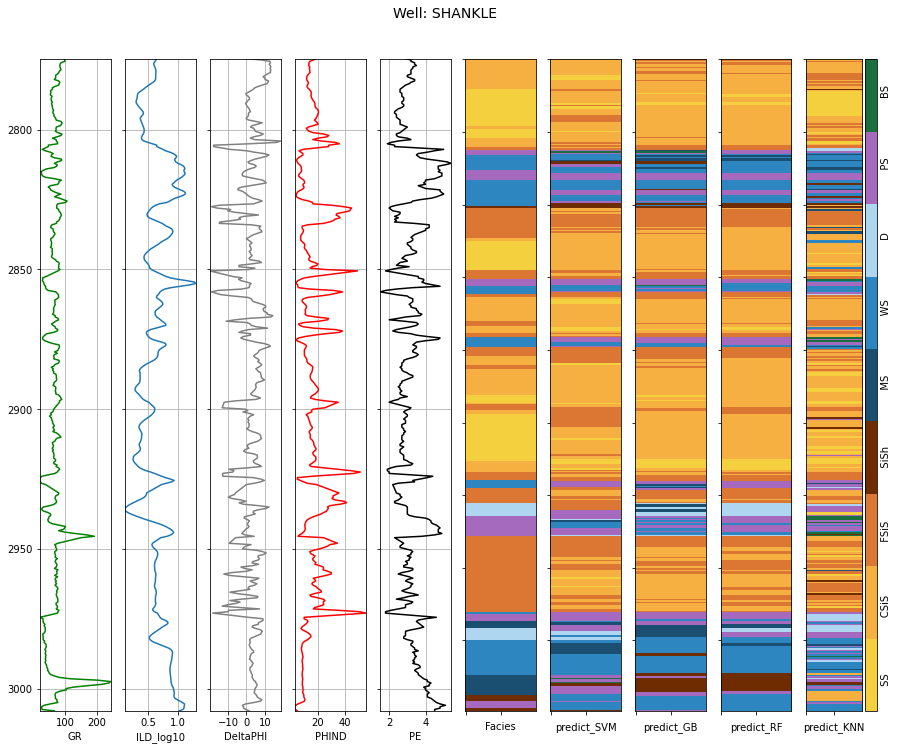

In [ ]:
compare_facies_plot(blind, 'predict_SVM', 'predict_GB', 'predict_RF', 'predict_KNN', facies_colors)

A-B test to evaluate the difference in F1 score:

1. Get the F1 score 100 times for each algorithms  
2. A-B test on the average F1 between RF and others


In [ ]:
list0 = []
for i in range(0,100,1):
  X_train0, X_test0, y_train0, y_test0 = train_test_split(X, y, test_size=0.05)
  clf0 = ensemble.RandomForestClassifier(n_estimators=2000)
  clf0.fit(X_train0, y_train0)
  list0.append(clf0.score(X_test0, y_test0))
  print(i, clf0.score(X_test0, y_test0))



0 0.7642857142857142
1 0.7214285714285714
2 0.7357142857142858
3 0.75
4 0.7428571428571429
5 0.7642857142857142
6 0.7142857142857143
7 0.75
8 0.7428571428571429
9 0.7928571428571428
10 0.7142857142857143
11 0.7785714285714286
12 0.7285714285714285
13 0.7928571428571428
14 0.7071428571428572
15 0.7642857142857142
16 0.6642857142857143
17 0.7214285714285714
18 0.7714285714285715
19 0.7642857142857142
20 0.7214285714285714
21 0.7214285714285714
22 0.75
23 0.7428571428571429
24 0.7142857142857143
25 0.8142857142857143
26 0.7428571428571429
27 0.75
28 0.7571428571428571
29 0.7285714285714285
30 0.7285714285714285
31 0.7428571428571429
32 0.7857142857142857
33 0.7285714285714285
34 0.7214285714285714
35 0.7571428571428571
36 0.7357142857142858
37 0.7357142857142858
38 0.8
39 0.7285714285714285
40 0.7428571428571429
41 0.7642857142857142
42 0.7357142857142858
43 0.65
44 0.7642857142857142
45 0.7785714285714286
46 0.7428571428571429
47 0.7642857142857142
48 0.7285714285714285
49 0.807142857142

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f36d82a0a20>]],
      dtype=object)

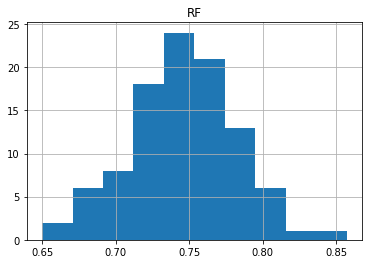

In [ ]:
df0 = pd.DataFrame(list0, columns=['RF'])
df0.hist()

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
list0 = []
for i in range(0,100,1):
  X_train0, X_test0, y_train0, y_test0 = train_test_split(X, y, test_size=0.05)
  clf0 = KNeighborsClassifier(weights='distance')
  clf0.fit(X_train0, y_train0)
  list0.append(clf0.score(X_test0, y_test0))
  print(i, clf0.score(X_test0, y_test0))

0 0.4857142857142857
1 0.55
2 0.5571428571428572
3 0.4714285714285714
4 0.5214285714285715
5 0.4857142857142857
6 0.4857142857142857
7 0.5071428571428571
8 0.4928571428571429
9 0.5428571428571428
10 0.5071428571428571
11 0.5357142857142857
12 0.6
13 0.5
14 0.5857142857142857
15 0.4785714285714286
16 0.5642857142857143
17 0.5928571428571429
18 0.5214285714285715
19 0.5285714285714286
20 0.5071428571428571
21 0.5214285714285715
22 0.5071428571428571
23 0.5571428571428572
24 0.6285714285714286
25 0.5
26 0.5714285714285714
27 0.5071428571428571
28 0.4714285714285714
29 0.4642857142857143
30 0.4857142857142857
31 0.5785714285714286
32 0.55
33 0.4642857142857143
34 0.5928571428571429
35 0.5357142857142857
36 0.5142857142857142
37 0.4928571428571429
38 0.5571428571428572
39 0.5571428571428572
40 0.5714285714285714
41 0.5928571428571429
42 0.5071428571428571
43 0.6071428571428571
44 0.5142857142857142
45 0.5071428571428571
46 0.5285714285714286
47 0.5785714285714286
48 0.55
49 0.52142857142857

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f36da3b70f0>]],
      dtype=object)

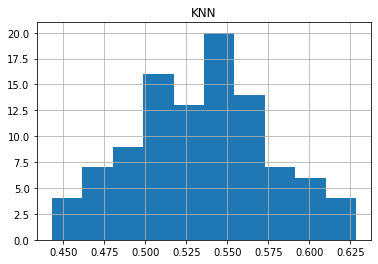

In [ ]:
df1 = pd.DataFrame(list0, columns=['KNN'])
df1.hist()

In [ ]:
from scipy import stats

In [ ]:
stats.ttest_ind(df0['RF'],df1['KNN'])

Ttest_indResult(statistic=37.85139665039692, pvalue=1.3333523854178673e-92)

In [ ]:
list0 = []
for i in range(0,100,1):
  X_train0, X_test0, y_train0, y_test0 = train_test_split(X_stnd, y, test_size=0.05)
  clf0 = SVC(C=10, gamma=1)
  clf0.fit(X_train0, y_train0)
  list0.append(clf0.score(X_test0, y_test0))
  print(i, clf0.score(X_test0, y_test0))

0 0.7571428571428571
1 0.7357142857142858
2 0.7785714285714286
3 0.6571428571428571
4 0.7428571428571429
5 0.7357142857142858
6 0.7285714285714285
7 0.7714285714285715
8 0.7285714285714285
9 0.7071428571428572
10 0.7928571428571428
11 0.7285714285714285
12 0.7571428571428571
13 0.7142857142857143
14 0.8
15 0.7357142857142858
16 0.7142857142857143
17 0.7071428571428572
18 0.8
19 0.7785714285714286
20 0.7642857142857142
21 0.7071428571428572
22 0.7571428571428571
23 0.7928571428571428
24 0.6928571428571428
25 0.7571428571428571
26 0.7571428571428571
27 0.7714285714285715
28 0.7
29 0.8071428571428572
30 0.7571428571428571
31 0.8
32 0.7642857142857142
33 0.7285714285714285
34 0.7285714285714285
35 0.7285714285714285
36 0.7785714285714286
37 0.7285714285714285
38 0.8071428571428572
39 0.7714285714285715
40 0.7857142857142857
41 0.7785714285714286
42 0.7071428571428572
43 0.7357142857142858
44 0.7928571428571428
45 0.7571428571428571
46 0.7714285714285715
47 0.7571428571428571
48 0.785714285

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f36f2315278>]],
      dtype=object)

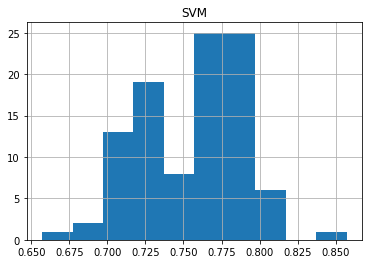

In [ ]:
df2 = pd.DataFrame(list0, columns=['SVM'])
df2.hist()

In [ ]:
stats.ttest_ind(df0['RF'],df2['SVM'])

Ttest_indResult(statistic=-1.7043710576071207, pvalue=0.08988042427111864)

In [ ]:
list0 = []
params = {'loss': 'deviance', ##  loss{‘deviance’, ‘exponential’}, default=’deviance’
          'learning_rate': 0.2, ##  learning_ratefloat, default=0.1
          'n_estimators': 1000, ##  number of iterations, int, default=100
          'max_depth': 3, ##  int, default=3
          'subsample': 0.6, ## float, default=1.0
          'min_samples_split': 2 ## int or float, default=2
          }
for i in range(0,100,1):
  X_train0, X_test0, y_train0, y_test0 = train_test_split(X, y, test_size=0.05)
  clf0 = ensemble.GradientBoostingClassifier(**params)
  clf0.fit(X_train0, y_train0)
  list0.append(clf0.score(X_test0, y_test0))
  print(i, clf0.score(X_test0, y_test0))

0 0.6928571428571428
1 0.7214285714285714
2 0.6285714285714286
3 0.6571428571428571
4 0.6785714285714286
5 0.6928571428571428
6 0.6571428571428571
7 0.7642857142857142
8 0.6357142857142857
9 0.5214285714285715
10 0.7571428571428571
11 0.6142857142857143
12 0.7214285714285714
13 0.65
14 0.6142857142857143
15 0.6785714285714286
16 0.6928571428571428
17 0.6357142857142857
18 0.7142857142857143
19 0.65
20 0.65
21 0.7285714285714285
22 0.7357142857142858
23 0.6
24 0.6428571428571429
25 0.6785714285714286
26 0.7357142857142858
27 0.6071428571428571
28 0.6785714285714286
29 0.05
30 0.6571428571428571
31 0.7071428571428572
32 0.6214285714285714
33 0.6714285714285714
34 0.65
35 0.6857142857142857
36 0.6928571428571428
37 0.5928571428571429
38 0.5928571428571429
39 0.6571428571428571
40 0.65
41 0.6285714285714286
42 0.6714285714285714
43 0.6571428571428571
44 0.65
45 0.6928571428571428
46 0.6642857142857143
47 0.6642857142857143
48 0.014285714285714285
49 0.7142857142857143
50 0.6928571428571428

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f1221f07a20>]],
      dtype=object)

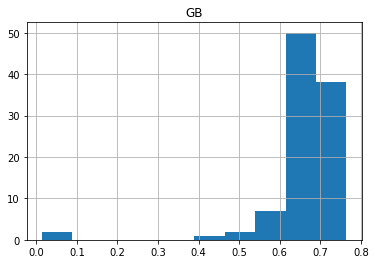

In [ ]:
df3 = pd.DataFrame(list0, columns=['GB'])
df3.hist()

In [ ]:
list_RF = [0.764285714,0.721428571,0.735714286,0.75,0.742857143,0.764285714,0.714285714,0.75,0.742857143,0.792857143,
           0.714285714,0.778571429,0.728571429,0.792857143,0.707142857,0.764285714,0.664285714,0.721428571,0.771428571,0.764285714,0.721428571,
           0.721428571,0.75,0.742857143,0.714285714,0.814285714,0.742857143,0.75,0.757142857,0.728571429,0.728571429,0.742857143,0.785714286,
           0.728571429,0.721428571,0.757142857,0.735714286,0.735714286,0.8,0.728571429,0.742857143,0.764285714,0.735714286,0.65,0.764285714,0.778571429,
           0.742857143,0.764285714,0.728571429,0.807142857,0.778571429,0.707142857,0.707142857,0.771428571,0.7,0.707142857,0.742857143,0.685714286,0.714285714,
           0.742857143,0.778571429,0.671428571,0.792857143,0.764285714,0.735714286,0.757142857,0.792857143,0.807142857,0.721428571,0.771428571,0.735714286,0.714285714,
           0.764285714,0.742857143,0.735714286,0.757142857,0.757142857,0.692857143,0.821428571,0.707142857,0.721428571,0.735714286,0.7,0.685714286,0.685714286,0.778571429,
           0.792857143,0.735714286,0.757142857,0.792857143,0.742857143,0.771428571,0.764285714,0.778571429,0.857142857,0.807142857,0.685714286,0.678571429,0.807142857,0.757142857]

In [ ]:
list_GB = [0.692857142857142,0.721428571428571,0.628571428571428,0.657142857142857,0.678571428571428,0.692857142857142,0.657142857142857,0.764285714285714,0.635714285714285,0.521428571428571,0.757142857142857,
           0.614285714285714,0.721428571428571,0.65,0.614285714285714,0.678571428571428,0.692857142857142,0.635714285714285,0.714285714285714,0.65,0.65,0.728571428571428,0.735714285714285,0.6,0.642857142857142,
           0.678571428571428,0.735714285714285,0.607142857142857,0.678571428571428,0.05,0.657142857142857,0.707142857142857,0.621428571428571,0.671428571428571,0.65,0.685714285714285,0.692857142857142,0.592857142857142,
           0.592857142857142,0.657142857142857,0.65,0.628571428571428,0.671428571428571,0.657142857142857,0.65,0.692857142857142,0.664285714285714,0.664285714285714,0.0142857142857142,0.714285714285714,0.692857142857142,
           0.685714285714285,0.65,0.692857142857142,0.65,0.621428571428571,0.692857142857142,0.614285714285714,0.571428571428571,0.714285714285714,0.678571428571428,0.664285714285714,0.735714285714285,0.628571428571428,
           0.707142857142857,0.635714285714285,0.65,0.628571428571428,0.692857142857142,0.707142857142857,0.714285714285714,0.635714285714285,0.742857142857142,0.664285714285714,0.407142857142857,0.707142857142857,0.707142857142857,
           0.757142857142857,0.635714285714285,0.685714285714285,0.721428571428571,0.657142857142857,0.714285714285714,0.635714285714285,0.707142857142857,0.707142857142857,0.642857142857142,0.735714285714285,0.764285714285714,
           0.485714285714285,0.664285714285714,0.55,0.7,0.721428571428571,0.621428571428571,0.7,0.657142857142857,0.621428571428571,0.707142857142857,0.55]

In [ ]:
df_RF = pd.DataFrame(list_RF, columns=['RF'])
df_GB = pd.DataFrame(list_GB, columns=['GB'])

In [ ]:
from scipy import stats
stats.ttest_ind(df_RF['RF'],df_GB['GB'])

Ttest_indResult(statistic=8.330960491186465, pvalue=1.3183937146753801e-14)

Ttest shows difference between between RF and GF is significant pvalue=1.3183937146753801e-14

Ttest shows difference between between RF and SVM is **NOT** significant pvalue=pvalue=0.08988042427111864

Ttest shows difference between between RF and KNN is significant pvalue=pvalue=1.3333523854178673e-92